
DATASET

\\


The Fake-or-Real Dataset : https://bil.eecs.yorku.ca/datasets/

version: for-2sec with the files truncated at 2 seconds

\\


**Training** dataset - two directorios: real and fake


\\

dataset/

├── real/

│   ├── real_audio_1.wav

│   ├── real_audio_2.wav

│   └── ...

└── fake/

│   ├── fake_audio_1.wav

│   ├── fake_audio_2.wav

│   └── ...


\\

**Test** dataset - all files (real and fake) in the same directory. For prediction was used a sample of the dataset test, around 400 files.

\\

In [1]:
# Load google driver
from google.colab import drive
# Mount Google Drive
# Ask permission to Gmail user
drive.mount('/drive')

Mounted at /drive


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install librosa tensorflow


In [4]:
# Import libraries
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [5]:
# Set the paths to dataset
data_path ='drive/My Drive/Colab Notebooks/datasets/for-2sec-training'
test_data_path = 'drive/My Drive/Colab Notebooks/datasets/audio_fake_real_validation'

runtime below: 7 minutes

In [6]:
# Function to load and preprocess audio data
def load_and_preprocess_data(data_dir, label):
    data = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            audio_data, _ = librosa.load(file_path, sr=16000)
            data.append(audio_data)
            labels.append(label)

    return data, labels

# Load and preprocess the dataset
real_data, real_labels = load_and_preprocess_data(os.path.join(data_path, 'real'), label=0)
fake_data, fake_labels = load_and_preprocess_data(os.path.join(data_path, 'fake'), label=1)

# Combine real and fake data
data = np.array(real_data + fake_data)
labels = np.array(real_labels + fake_labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Function to preprocess audio data to spectrograms
def preprocess_audio(audio_data):
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000)
    # Convert to decibels (log scale)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

X_train = np.array([preprocess_audio(audio) for audio in X_train])
X_val = np.array([preprocess_audio(audio) for audio in X_val])

In [8]:
# Function to count instances of the "real" class
def count_real_instances(labels):
    return sum(label == 0 for label in labels)

# Count "real" instances in X_train and X_val
real_instances_train = count_real_instances(y_train)
real_instances_val = count_real_instances(y_val)

print(f"Number of 'real' instances in X_train: {real_instances_train}")
print(f"Number of 'real' instances in X_val: {real_instances_val}")


def count_fake_instances(labels):
    return sum(label == 1 for label in labels)

# Count "real" instances in X_train and X_val
fake_instances_train = count_fake_instances(y_train)
fake_instances_val = count_fake_instances(y_val)

print(f"Number of 'fake' instances in X_train: {fake_instances_train}")
print(f"Number of 'fake' instances in X_val: {fake_instances_val}")

Number of 'real' instances in X_train: 5569
Number of 'real' instances in X_val: 1409
Number of 'fake' instances in X_train: 5595
Number of 'fake' instances in X_val: 1383


runtime below: 1,5 minutes

In [22]:
X_train

array([[ 0.06698608,  0.06994629,  0.0713501 , ..., -0.1312561 ,
        -0.13070679, -0.10842896],
       [-0.04629517, -0.05166626, -0.0569458 , ...,  0.16442871,
         0.02224731, -0.0123291 ],
       [-0.03512573, -0.00061035,  0.01779175, ...,  0.17831421,
         0.14752197,  0.14041138],
       ...,
       [-0.07485962, -0.07247925, -0.07177734, ...,  0.00686646,
         0.00473022,  0.00057983],
       [ 0.10461426,  0.12939453,  0.08740234, ...,  0.05090332,
         0.04348755,  0.00949097],
       [ 0.06408691,  0.05105591,  0.01681519, ...,  0.04083252,
         0.0385437 ,  0.03585815]], dtype=float32)

In [9]:
# Define the deep learning model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Predict authenticity on the test dataset (dataset with files to be predict)
def predict_authenticity(model, data_path):
    data = []

    for audio_file in os.listdir(data_path):
        if audio_file.endswith('.wav'):
            file_path = os.path.join(data_path, audio_file)
            audio_data, _ = librosa.load(file_path, sr=16000)
            audio_data = preprocess_audio(audio_data)
            audio_data = np.expand_dims(audio_data, axis=0)

            prediction = model.predict(audio_data)
            label = 'fake' if prediction > 0.5 else 'real'
            data.append([audio_file, label])

    df = pd.DataFrame(data, columns=['Audio Filename', 'Label'])

    return df

# Predict on the test dataset and display the results in a DataFrame
test_results = predict_authenticity(model, test_data_path)
print(test_results)


Epoch 1/10
349/349 [==============================] - 14s 7ms/step - loss: 0.9865 - accuracy: 0.6165 - val_loss: 0.5705 - val_accuracy: 0.7095
Epoch 2/10
349/349 [==============================] - 2s 6ms/step - loss: 0.4787 - accuracy: 0.7803 - val_loss: 0.3782 - val_accuracy: 0.8406
Epoch 3/10
349/349 [==============================] - 2s 5ms/step - loss: 0.3857 - accuracy: 0.8295 - val_loss: 0.3831 - val_accuracy: 0.8105
Epoch 4/10
349/349 [==============================] - 2s 6ms/step - loss: 0.3233 - accuracy: 0.8602 - val_loss: 0.3115 - val_accuracy: 0.8589
Epoch 5/10
349/349 [==============================] - 3s 8ms/step - loss: 0.2614 - accuracy: 0.8913 - val_loss: 0.2107 - val_accuracy: 0.9144
Epoch 6/10
349/349 [==============================] - 3s 8ms/step - loss: 0.2149 - accuracy: 0.9130 - val_loss: 0.1640 - val_accuracy: 0.9355
Epoch 7/10
349/349 [==============================] - 3s 8ms/step - loss: 0.1591 - accuracy: 0.9391 - val_loss: 0.1324 - val_accuracy: 0.9513
Epoch

In [11]:
# count fake audio in the test dataset (predict)
count_fake=0
for i in range(400):
  if test_results.Label[i] =='fake' :
    count_fake= count_fake+1
print("COUNT FAKE: ",count_fake)

COUNT FAKE:  241


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 16)           3040      
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 16)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 64)                6

88/88 [==============================] - 0s 2ms/step


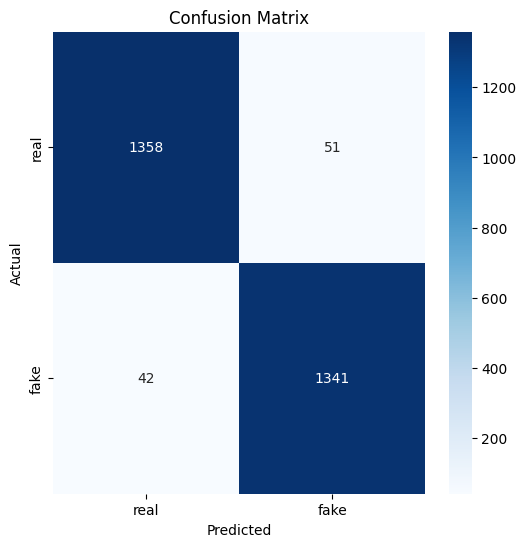

In [13]:
#CONFUSION MATRIX FOR VALIDATION DATA USED TO TRAIN THE MODEL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, labels, title='Confusion Matrix'):
    # Get model predictions
    y_pred = model.predict(X)
    y_pred = np.round(y_pred)  # Convert probabilities to binary labels

    # Generate a confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(6, 6))

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)

    # Show the plot
    plt.show()

plot_confusion_matrix(model, X_val, y_val, labels=['real', 'fake'])


[-0.10726639 -0.11896672 -0.10226737 ... -0.12161377 -0.1365962
 -0.08514544] 22050


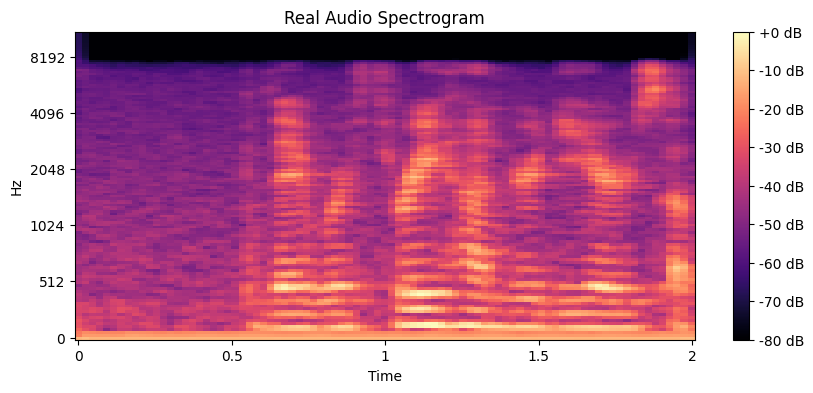

[ 0.31815138  0.26314637  0.00566594 ... -0.15579155  0.0235047
  0.10799523] 22050


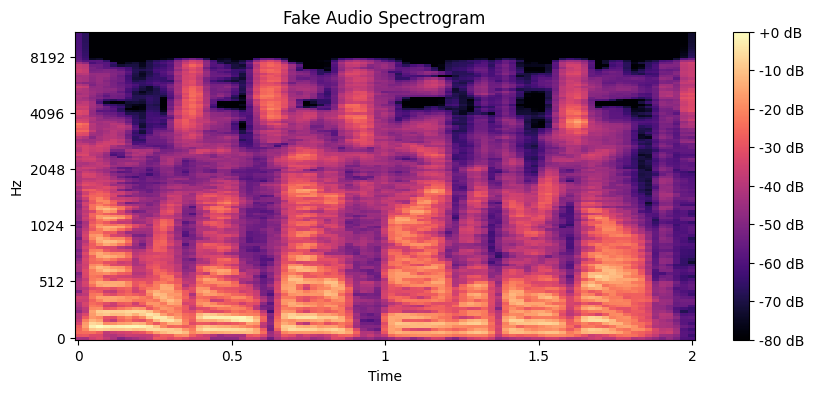

In [14]:
import librosa.display
import matplotlib.pyplot as plt

def plot_audio_spectrogram(audio_path, title):
    # Load the audio file
    audio_data, sample_rate = librosa.load(audio_path)
    print(audio_data, sample_rate)

    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


plot_audio_spectrogram('drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav', 'Real Audio Spectrogram')
plot_audio_spectrogram('drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file242_fake.wav', 'Fake Audio Spectrogram')


In [15]:
# PREDICT IF A SINGLE AUDIO IS REAL OR FAKE

import librosa
import numpy as np

# Function to preprocess audio data to spectrograms
def preprocess_audio(audio_data):
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000)
    # Convert to decibels (log scale)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to predict if a single audio file is real or fake
def predict_single_audio(model, audio_path):
    # Load the audio file
    audio_data, _ = librosa.load(audio_path, sr=16000)

    # Preprocess the audio data
    preprocessed_audio = preprocess_audio(audio_data)
    preprocessed_audio = np.expand_dims(preprocessed_audio, axis=0)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_audio)

    # Determine the label based on the prediction
    label = 'fake' if prediction > 0.5 else 'real'

    return label


result = predict_single_audio(model, 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file48_fake.wav')
print(f"The audio is predicted to be {result}.")

result = predict_single_audio(model, 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav')
print(f"The audio is predicted to be {result}.")


1/1 [==============================] - 0s 28ms/step
The audio is predicted to be fake.
1/1 [==============================] - 0s 28ms/step
The audio is predicted to be real.


# Play audio

In [ ]:
from IPython.display import Audio, display
import time
time.sleep(3)

def play_audio_files(real_audio_file, fake_audio_file):
    # Load audio files
    real_audio = AudioSegment.from_wav(real_audio_file)
    fake_audio = AudioSegment.from_wav(fake_audio_file)

    # Play real audio
    print("Playing Real Audio...")
    #play(real_audio)
    display(Audio(real_audio_file, autoplay=True))

    time.sleep(5)
    # Play fake audio
    print("Playing Fake Audio...")
    # play(fake_audio)
    display(Audio(fake_audio_file, autoplay=True))

fake_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file48_fake.wav'
real_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav'

play_audio_files(real_audio_file, fake_audio_file)


Playing Real Audio...


Playing Fake Audio...
